In [1]:
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas

%matplotlib inline

In [2]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

In [4]:
#TODO
domain = [0, 1]
n_discretization = 300 * domain[1] - domain[0] 

In [5]:
n_input = 1
n_output = 1
eps = 1e-10

In [6]:
x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization).reshape(-1,1)
x = Variable(x, requires_grad=True).double()

In [7]:
#TODO
mlp = nn.Sequential(
  nn.Linear(n_input, 32),
  nn.Tanh(),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),        
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()

In [8]:
#TODO
def get_loss(x, ret_res=False):    
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)

  residual = x * y_xx + 2 * y_x + x
  
  boundary1 = y[0] - 1
  boundary2 = y_x[0] - 0

  loss = (residual**2).mean() + boundary1**2 + boundary2**2
  return (loss, residual) if ret_res else loss

In [9]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [10]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 1000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00000.8868075047
Step: 002 loss = 00000.6797126970
Step: 004 loss = 00000.1904151008
Step: 006 loss = 00000.1468792872
Step: 008 loss = 00000.0704955848
Step: 010 loss = 00000.0951852870
Step: 012 loss = 00000.0362264451
Step: 014 loss = 00000.0638399056
Step: 016 loss = 00000.0203398251
Step: 018 loss = 00000.0243376087
Step: 020 loss = 00000.0142680096
Step: 022 loss = 00000.0039039279
Step: 024 loss = 00000.0170419651
Step: 026 loss = 00000.0081500878
Step: 028 loss = 00000.0153933343
Step: 030 loss = 00000.0049060056
Step: 032 loss = 00000.0080316754
Step: 034 loss = 00000.0012177620
Step: 036 loss = 00000.0037919501
Step: 038 loss = 00000.0011681314
Step: 040 loss = 00000.0024160845
Step: 042 loss = 00000.0018941676
Step: 044 loss = 00000.0021346492
Step: 046 loss = 00000.0020968615
Step: 048 loss = 00000.0013690388
Step: 050 loss = 00000.0015543761
Step: 052 loss = 00000.0006885427
Step: 054 loss = 00000.0010240616
Step: 056 loss = 00000.0003513908
Step: 058 loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


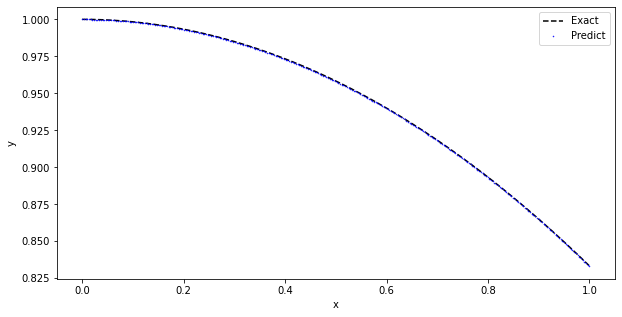

In [11]:
#[TODO]
domain = x.detach().numpy().flatten()
exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

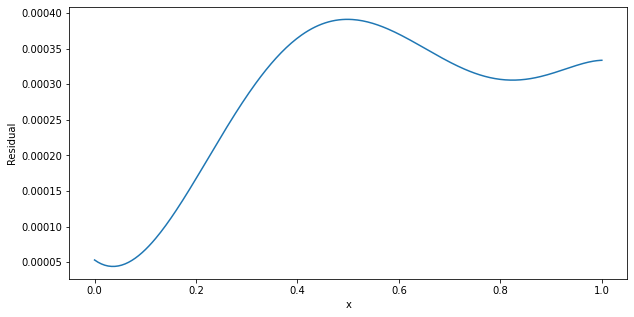

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(domain, exact - predict, label='residual')
plt.xlabel('x')
plt.ylabel('Residual')
plt.savefig('residual-exact.eps', bbox_inches='tight', format='eps')


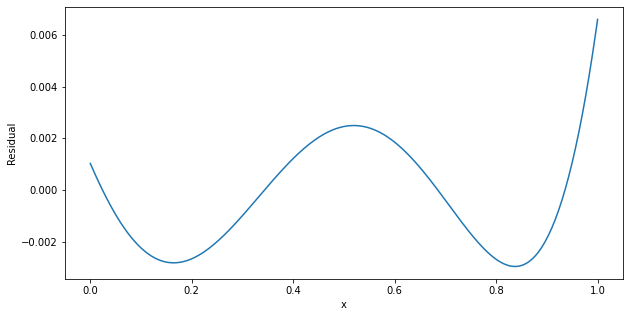

In [13]:
plt.figure(figsize=(10, 5))

res= get_loss(x, ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

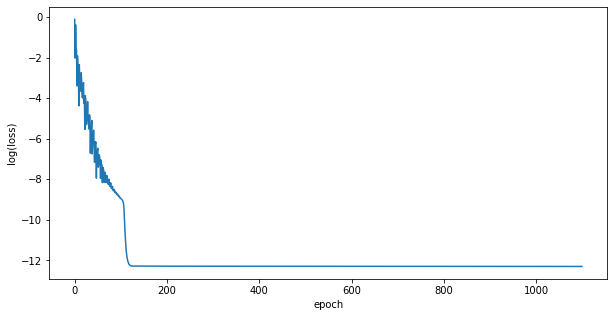

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')

In [15]:

def l1_norm(vector0, vector1):
  return sum(abs(a-b) for a, b in zip(vector0, vector1))

def l_inf_norm(vector0, vector1):
  return max(abs(a-b) for a, b in zip(vector0, vector1))

def l2_norm(vector0, vector1):
  return (sum((a-b)**2 for a, b in zip(vector0, vector1))) ** .5

def relative_l2(vector0, vector1):
  return np.linalg.norm(vector0 - vector1, 2)/np.linalg.norm(vector0,2)


measure_names = []
measure_values = []
for measure in [
  mean_squared_error,
  l1_norm,
  l2_norm,
  l_inf_norm,
  relative_l2,
  mean_absolute_error

]:
  measure_names.append(measure.__name__)
  measure_values.append(measure(exact, predict))
df = pandas.DataFrame(dict(name=measure_names, values=measure_values)).reset_index(drop=True)
print(df.to_latex(), file=open('latex_table.txt', 'w'))
df

/tmp/ipykernel_107557/1445887567.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(), file=open('latex_table.txt', 'w'))


,name,values
0,mean_squared_error,8.942052e-08
1,l1_norm,8.348959e-02
2,l2_norm,5.179397e-03
3,l_inf_norm,3.911157e-04
4,relative_l2,3.162134e-04
5,mean_absolute_error,2.782986e-04
